Nesta parte do projeto irei dar segmento a construção do modelo de aprendizado de maquina para segmentação de clientes. O modelo que será utilizado será um modelo não supervisionado. A ideia é agrupar e resumir segmentos de cliente de uma loja de varejo, identificando grupos de clientes ideais para um programa de fidelidade.

# 1. Importando Bibliotecas

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from datetime import datetime

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture




from utils import *

# 2. Carregando Dataset

In [2]:
path= r'input\marketing_campaign.csv'
customer = pd.read_csv(path, sep="\t")
customer.head(5)

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  04-09-2012       58       635         88              546              172   
1  08-03-2014       38        11          1                6                2   
2  21-08-2013       26       426         49              127              111   
3  10-02-2014       26        11          4               20               10   
4  19-01-2014       94       173         43              118               46   

   MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
0                88            88                  3                8   
1                 1             6                  2                1   
2                21            42                  1                8   
3                 3             5                  2                2   
4                27            15                  5                5   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  \
0                   10                  4                  7             0   
1                    1                  2                  5             0   
2                    2                 10                  4             0   
3                    0                  4                  6             0   
4                    3                  6                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0

## 3. Feature Engeneering

In [3]:
clustering_customer, idx = feature_engineering(customer)

In [4]:
clustering_customer.columns

Index(['education', 'marital_status', 'income', 'recency', 'wines', 'fruits',
       'meat', 'fish', 'sweets', 'gold', 'numdealspurchases',
       'numwebpurchases', 'numcatalogpurchases', 'numstorepurchases',
       'numwebvisitsmonth', 'dependents', 'age', 'relationship_duration',
       'frequency', 'monetary', 'avg_purchase_value'],
      dtype='object')

## 4. Limpeza e Pré Processamento

- Escolhi o KNN Imputer para lidar com os valores ausentes porque ele utiliza a similaridade entre observações para estimar valores, o que é ideal para capturar padrões locais no dataset. Além disso, ao considerar variáveis correlacionadas, como idade, estado civil e nível de educação, ele oferece uma abordagem mais robusta.
- Nesse Processo deverei usar o StandartScaler, para poder colocar os valores numericos na mesma escala.
- Para as Categóricas irei utilizar OrdinalEncoder,para a  feature education por representar uma relação ordinal e para marital_status devo transformar em binária.

In [5]:
clustering_customer.isna().sum()

education                 0
marital_status            0
income                   23
recency                   0
wines                     0
fruits                    0
meat                      0
fish                      0
sweets                    0
gold                      0
numdealspurchases         0
numwebpurchases           0
numcatalogpurchases       0
numstorepurchases         0
numwebvisitsmonth         0
dependents                0
age                       0
relationship_duration     0
frequency                 0
monetary                  0
avg_purchase_value        2
dtype: int64

In [6]:
numerical_features = clustering_customer.select_dtypes('number').columns.to_list()
categorical_features = clustering_customer.select_dtypes('object').columns.to_list()

numerical_pipeline = Pipeline(steps=[
    ('knn_imputer', KNNImputer()),
    ('stand_scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('ord_encoder',OrdinalEncoder()),
    ('stand_scaler',StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

In [7]:
processed_df = pd.DataFrame(preprocessor.fit_transform(clustering_customer))

In [8]:
processed_df.columns = clustering_customer.columns

In [9]:
processed_df.head()

education  marital_status    income   recency     wines    fruits  \
0   0.317619        0.307307  0.979727  1.550286  1.755827  2.456149   
1  -0.253280       -0.383626 -0.873488 -0.637803 -0.730377 -0.651835   
2   0.969888       -0.798186  0.359019  0.569418 -0.173283  1.340931   
3  -1.206779       -0.798186 -0.873488 -0.562352 -0.665920 -0.505577   
4   0.325122        1.550987 -0.392365  0.418516 -0.214720  0.152585   

       meat      fish    sweets      gold  numdealspurchases  numwebpurchases  \
0  1.471551  0.842345  0.358429  1.405182           2.633496        -0.559978   
1 -0.633150 -0.731880 -0.169383 -1.118159          -0.585846        -1.177160   
2 -0.149310 -0.040757 -0.697195  1.405182          -0.228141         1.291565   
3 -0.584766 -0.751077 -0.169383 -0.757682          -0.943550        -0.559978   
4 -0.004159 -0.559099  1.414053  0.323750           0.129564         0.057203   

   numcatalogpurchases  numstorepurchases  numwebvisitsmonth  dependents  \
0             0.689529          -1.267017           1.015275    1.501310   
1            -0.139543           1.393599           1.271558   -1.420017   
2            -0.554079          -1.267017           0.331856    0.040647   
3             0.274993           0.063291          -1.291266   -1.420017   
4            -0.139543           0.063291          -1.034984   -1.420017   

        age  relationship_duration  frequency  monetary  avg_purchase_value  
0  1.088291               1.684878   1.129377 -0.892864            1.345208  
1 -1.106179              -0.962467  -0.983387 -0.892864            1.345208  
2  0.812590               0.284616   0.155932 -0.892864           -0.743380  
3 -0.816554              -0.919177  -0.908784 -0.892864           -0.743380  
4  0.776387              -0.304793  -0.361616  0.572012           -0.743380

In [10]:
print(f'Nosso dataset é composto por {clustering_customer.shape[0]} linhas e {clustering_customer.shape[1]} colunas')

Nosso dataset é composto por 2228 linhas e 21 colunas


### Principal Component Analysis (PCA)

Reduzir a dimensionalidade dos dados, melhora a separação entre clusters, remove ruídos e informações irrelevantes. Essa técnica captura as variações mais significativas nos dados, tornando os agrupamentos mais claros, precisos e computacionalmente eficientes, facilitando a identificação de padrões.

In [11]:
pca = PCA()
pca.fit(processed_df)
pca.explained_variance_ratio_

array([4.09913293e-01, 1.00446366e-01, 6.00546092e-02, 5.03331139e-02,
       4.79359569e-02, 4.73684163e-02, 4.24988265e-02, 3.94177178e-02,
       3.30729153e-02, 2.95898503e-02, 2.61667242e-02, 2.24597167e-02,
       2.10412009e-02, 1.83912075e-02, 1.70060150e-02, 1.39478548e-02,
       1.15030900e-02, 6.76513030e-03, 1.99922021e-03, 8.87756699e-05,
       0.00000000e+00])

In [12]:
pca = PCA(n_components=3, random_state=42)
df_pca = pca.fit_transform(processed_df)
print(f'CP{pca.n_components_} Variância explicada por componente {np.sum(pca.explained_variance_ratio_):.3f}')

CP3 Variância explicada por componente 0.570


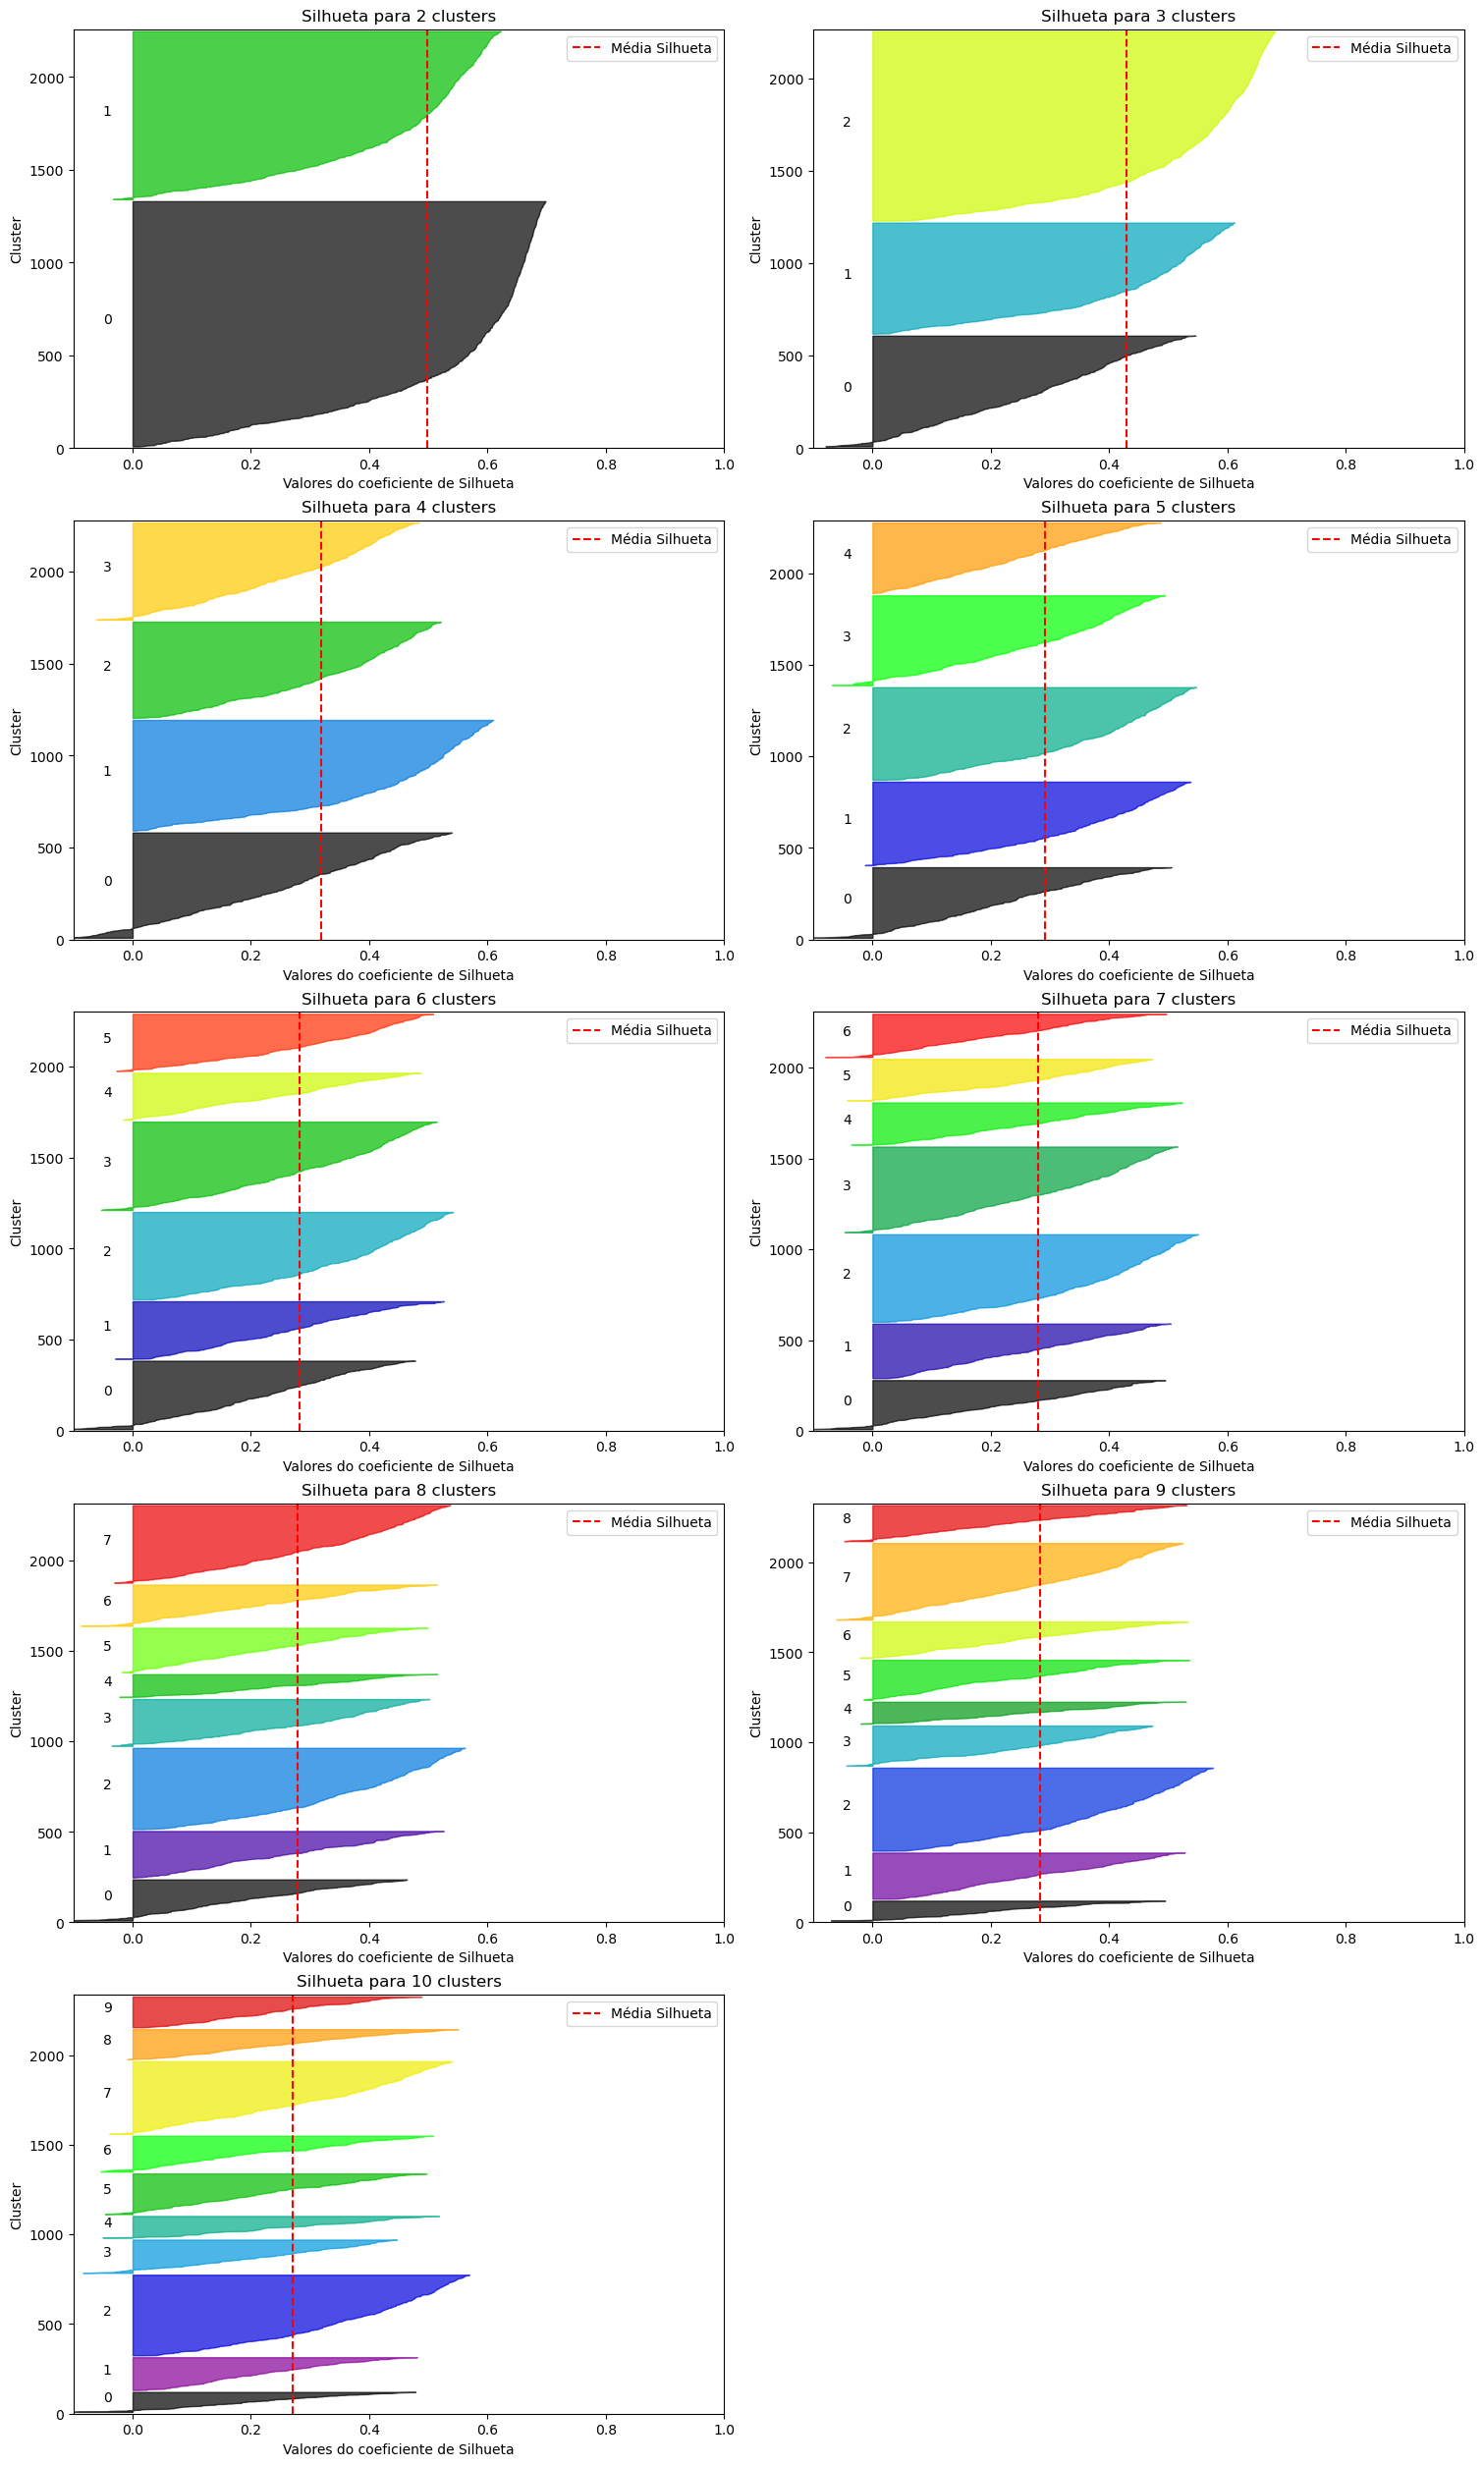

In [13]:
silhouette_scores = silhouette_analysis(df_pca)

In [14]:
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=100, max_iter=300, random_state=42)
kmeans.fit(df_pca)
labels = kmeans.labels_


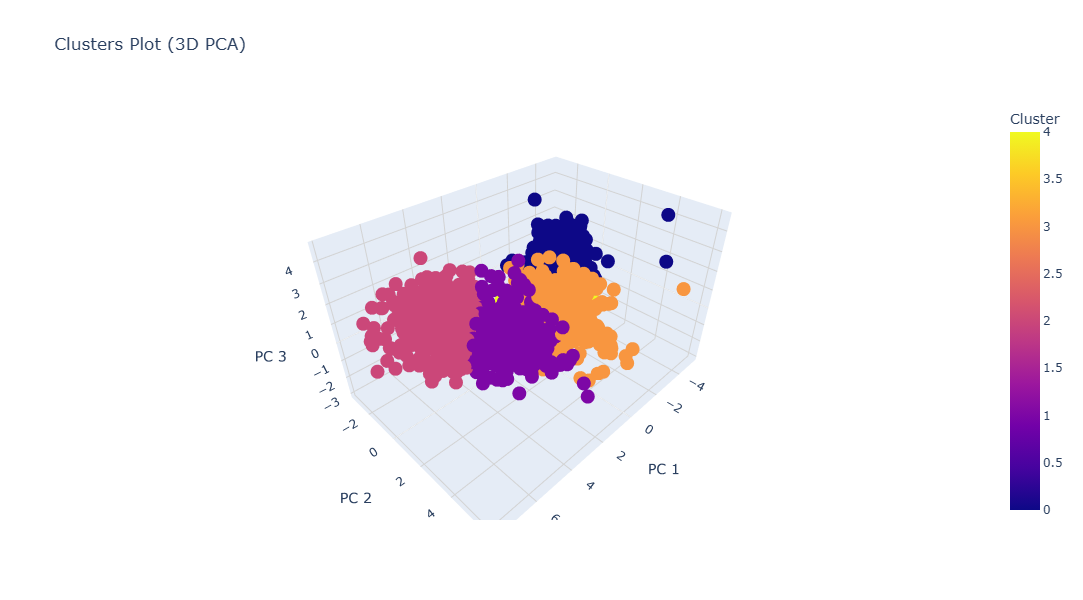

In [15]:
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2', 'PC3'])
df_pca['Cluster'] = labels

fig = px.scatter_3d(
    df_pca,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster',
    title='Clusters Plot (3D PCA)',
    labels={'PC1': 'PC 1', 'PC2': 'PC 2', 'PC3': 'PC 3'},
)

fig.update_layout(
    scene=dict(
        xaxis=dict(showline=True, zeroline=True, gridcolor='lightgray'),
        yaxis=dict(showline=True, zeroline=True, gridcolor='lightgray'),
        zaxis=dict(showline=True, zeroline=True, gridcolor='lightgray'),
    ),
    width=1200,  # Ajustando largura
    height=600  # Ajustando altura
)

fig.show()


## 5. Cluster Analysis

In [16]:
customer_clusters = clustering_customer.copy()
customer_clusters['clusters'] = labels
customer_clusters.head()

education marital_status   income  recency  wines  fruits  meat  fish  \
0      Graduate         Single  58138.0       58    635      88   546   172   
1      Graduate         Single  46344.0       38     11       1     6     2   
2      Graduate        Partner  71613.0       26    426      49   127   111   
3      Graduate        Partner  26646.0       26     11       4    20    10   
4  Postgraduate        Partner  58293.0       94    173      43   118    46   

   sweets  gold  numdealspurchases  numwebpurchases  numcatalogpurchases  \
0      88    88                  3                8                   10   
1       1     6                  2                1                    1   
2      21    42                  1                8                    2   
3       3     5                  2                2                    0   
4      27    15                  5                5                    3   

   numstorepurchases  numwebvisitsmonth  dependents  age  \
0                  4                  7           0   66   
1                  2                  5           2   69   
2                 10                  4           0   58   
3                  4                  6           1   39   
4                  6                  5           1   42   

   relationship_duration  frequency  monetary  avg_purchase_value  clusters  
0                     13   1.923077      1617           64.680000         2  
1                     11   0.545455        27            4.500000         4  
2                     12   1.750000       776           36.952381         1  
3                     11   0.727273        53            6.625000         4  
4                     11   1.727273       422           22.210526         3

In [17]:
numerical_features = customer_clusters.select_dtypes('number').columns.to_list()

grouped_clusters = customer_clusters.groupby(['clusters'])[numerical_features].mean()
grouped_clusters.sort_values(['income', 'monetary', 'frequency'], ascending=False)

income    recency       wines     fruits        meat  \
clusters                                                               
2         77717.758850  49.876923  629.087912  70.775824  498.505495   
1         65358.771429  49.144330  604.417526  43.175258  218.603093   
3         51136.127937  47.891473  310.661499  12.410853   87.007752   
4         41157.529540  50.191810   53.607759   4.663793   23.168103   
0         28676.206439  48.352060   26.114232   5.256554   20.132959   

                fish     sweets       gold  numdealspurchases  \
clusters                                                        
2         105.646154  74.112088  77.986813           1.043956   
1          55.840206  43.314433  75.252577           2.878866   
3          18.855297  12.713178  48.875969           4.423773   
4           6.202586   4.868534  13.051724           1.816810   
0           7.458801   5.305243  16.204120           1.917603   

          numwebpurchases  numcatalogpurchases  numstorepurchases  \
clusters                                                            
2                4.828571             6.094505           8.329670   
1                6.796392             4.546392           9.087629   
3                5.984496             2.072351           6.273902   
4                2.010776             0.661638           3.575431   
0                1.977528             0.432584           2.906367   

          numwebvisitsmonth  dependents        age  relationship_duration  \
clusters                                                                    
2                  2.430769    0.101099  54.070330              11.929670   
1                  4.963918    0.894330  57.631443              12.149485   
3                  6.552972    1.361757  57.317829              12.206718   
4                  5.232759    1.407328  57.627155              11.381466   
0                  7.292135    1.028090  46.226592              12.222846   

          frequency     monetary  avg_purchase_value  clusters  
clusters                                                        
2          1.704218  1456.114286           73.989176       2.0  
1          1.921902  1040.603093           46.071984       1.0  
3          1.540753   490.524548           25.889656       3.0  
4          0.708891   105.562500           11.340463       4.0  
0          0.592022    80.471910           10.527298       0.0

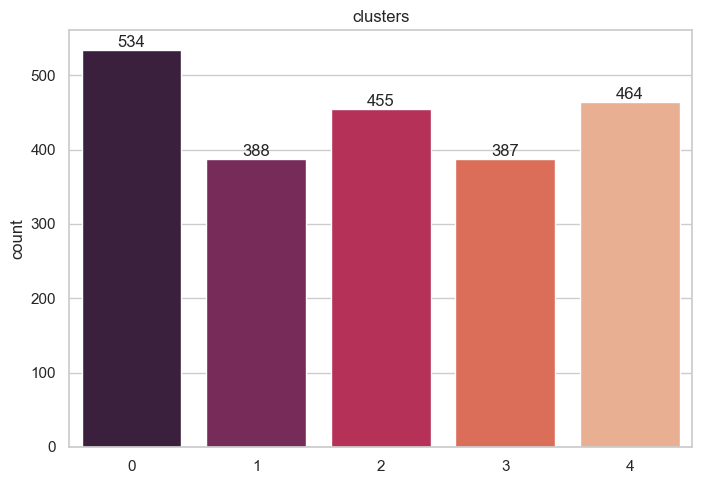

In [18]:
sns_plots(data=customer_clusters, features=['clusters'], plot_type='count',palette='rocket')

No geral os clusters possuem quase o mesmo tamanho sendo 1 e 3 os menores

**Cluster 2:**
**Clientes Premium**

- Número de clientes = 455
- Renda média = \$ 77.717,75
- Frequência média = 1.70
- Média monetária = \$1.456.11
- Valor médio de compra = \$ 73,98
- Preferem compras em lojas e catálogos.
- Tendem a fazer menos visitas à web por mês.
- Tendem a ter até 1 filho.

**Cluster 1:**
**Clientes Fiel**

- Número de clientes = 388
- Renda média = \$ 65.358,77
- Frequência média = 1.92
- Média monetária = \$ 104,06
- Valor médio de compra = $ 46,07
- Tendem a fazer compras em loja e web.
- visitando o site com frequência.
- Tendem a não ter filhos.

**Cluster 3:**
**Clientes Regular**

- Número de clientes = 387
- Renda média = \$ 51.136,12
- Frequência média = 1.54
- Média monetária = \$ 490,52
- Valor médio de compra = \$ 25,88
- Tendem a fazer compras em web e loja
- Tendem a visitar o site com frequência em um mês.
- Tendem a comprar com desconto.
- Tendem a ter 1 filho ou mais.


**Cluster 4:**
**Clientes em Risco**
	
- Número de clientes = 464
- Renda média = \$ 41.157,52
- Frequência média = 0.70
- Média monetária = \$ 105,56
- Valor médio de compra = \$ 11,34
- Tendem a visitar o site muito em um mês, não comprando muito.
- Tendem a fazer compras pela web ou catálogo.
- Tendem a ter 1 filho ou mais.


**Cluster 0:**
**Clientes Hibernando**

- Número de clientes = 534
- Renda média = \$ 28.676,20
- Frequência média = 0.59
- Média monetária = \$ 80,47
- Valor médio de compra = \$ 10,52
- Preferem compras em web e lojas.
- Compram com desconto
- Tendem a visitar o site com frequência em um mês.
- Tendem a ter até 1 filho.













- Recência e tempo de relacionamento  não demonstram nenhuma diferença significativa entre os clusters.
- Notamos que todos os clusters gastam mais com vinhos e carnes do que com outros produtos...

# Análise Exploratória

In [19]:
customer_clusters['clusters'].replace({0: 'Hibernando', 1: 'Fiel', 
                                 2: 'Premium', 3: 'Regular', 
                                 4: 'Risco'}, inplace=True)

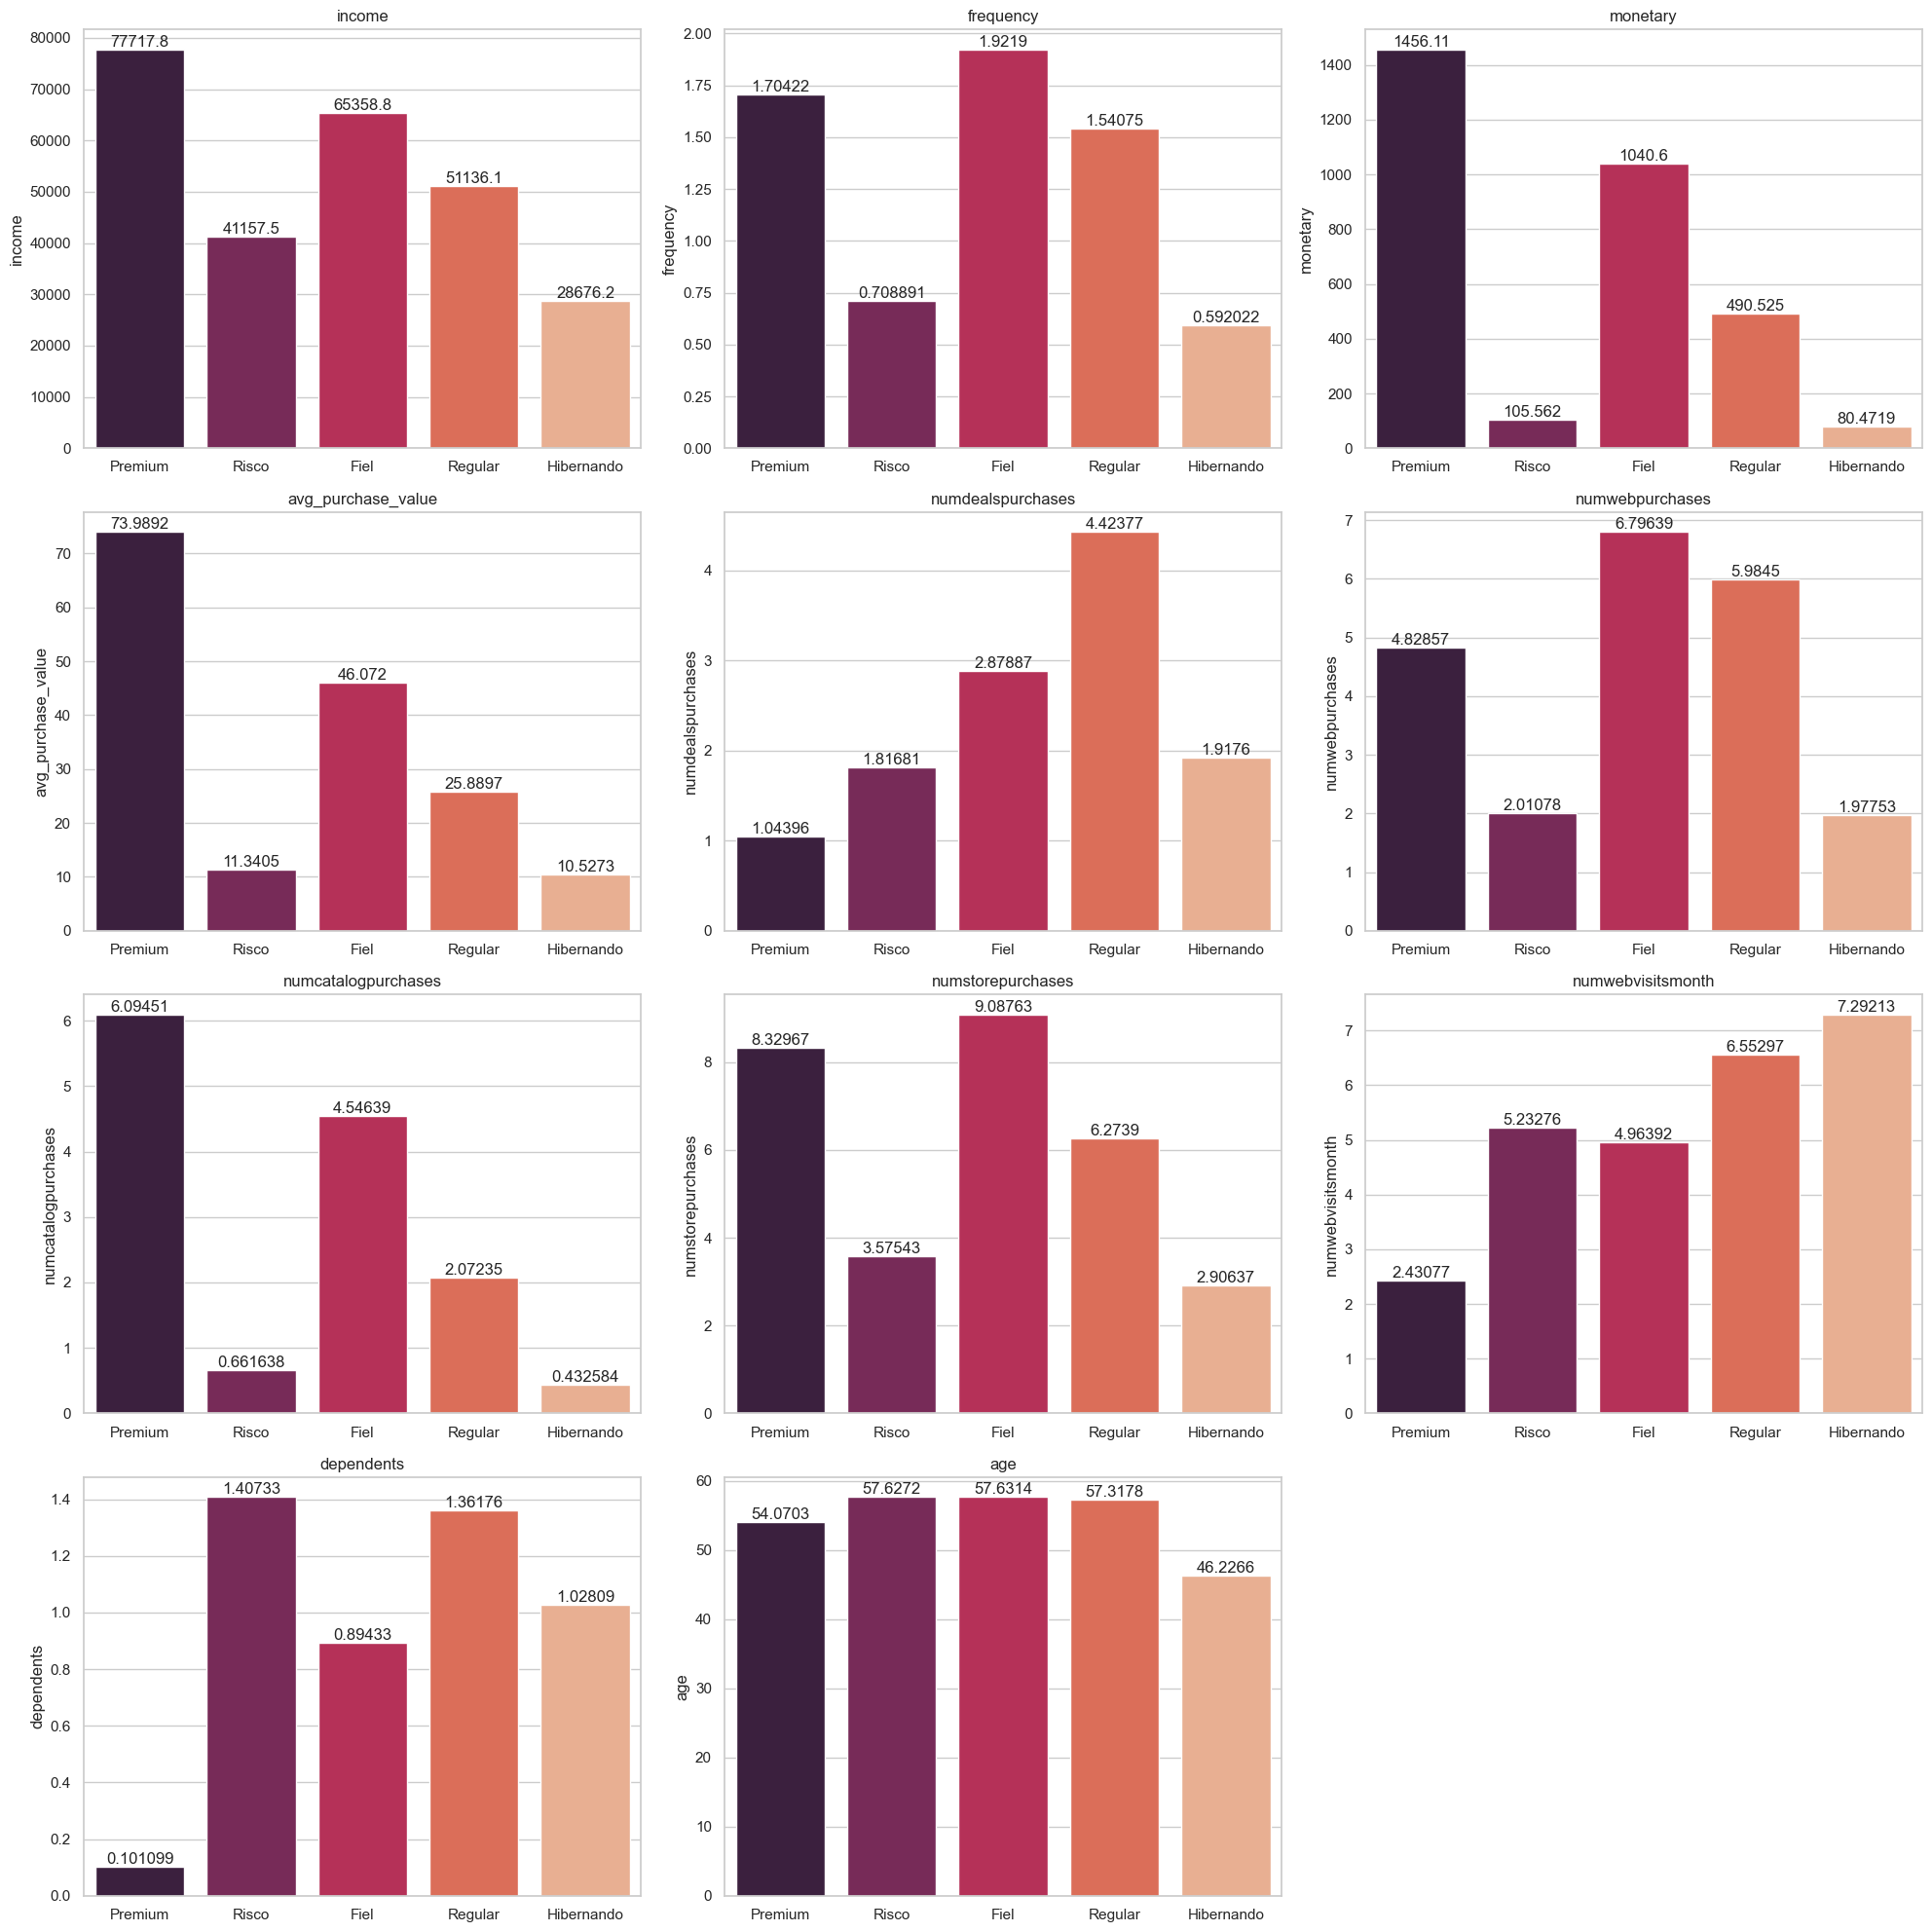

In [20]:
numplots_features = ['income', 'frequency', 'monetary', 'avg_purchase_value', 
                     'numdealspurchases', 'numwebpurchases', 'numcatalogpurchases', 'numstorepurchases', 
                     'numwebvisitsmonth', 'dependents', 'age']
sns_plots(data=customer_clusters, features=numplots_features, plot_type='barplot', x_feature='clusters',palette='rocket')

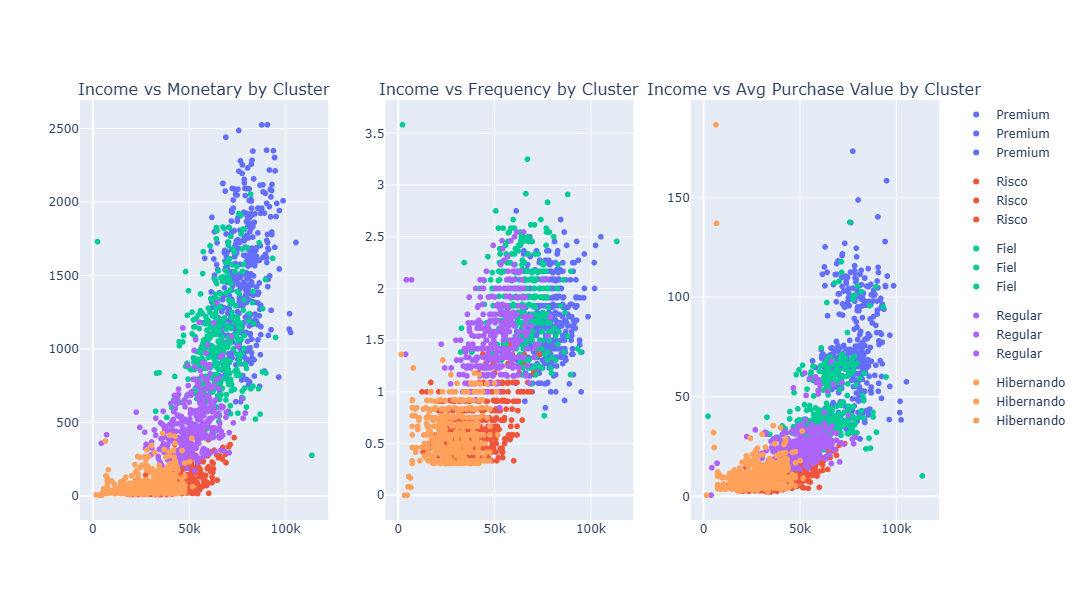

In [21]:
fig = make_subplots(rows=1, cols=3, subplot_titles=[
    'Income vs Monetary by Cluster',
    'Income vs Frequency by Cluster',
    'Income vs Avg Purchase Value by Cluster'
])
#Income vs Monetary
scatter1 = px.scatter(
    customer_clusters, 
    x='income', 
    y='monetary', 
    color='clusters'
)
for trace in scatter1.data:
    fig.add_trace(trace, row=1, col=1)

#Income vs Frequency
scatter2 = px.scatter(
    customer_clusters, 
    x='income', 
    y='frequency', 
    color='clusters'
)
for trace in scatter2.data:
    fig.add_trace(trace, row=1, col=2)

#Income vs Average Purchase Value
scatter3 = px.scatter(
    customer_clusters, 
    x='income', 
    y='avg_purchase_value', 
    color='clusters'
)
for trace in scatter3.data:
    fig.add_trace(trace, row=1, col=3)


fig.update_layout(
    height=600, 
    width=1200,
    showlegend=True,
    title_text=None
)


fig.show()


Consigo notar que realmente há uma separação entre clusters em income, monetary, frequency e avg purch value

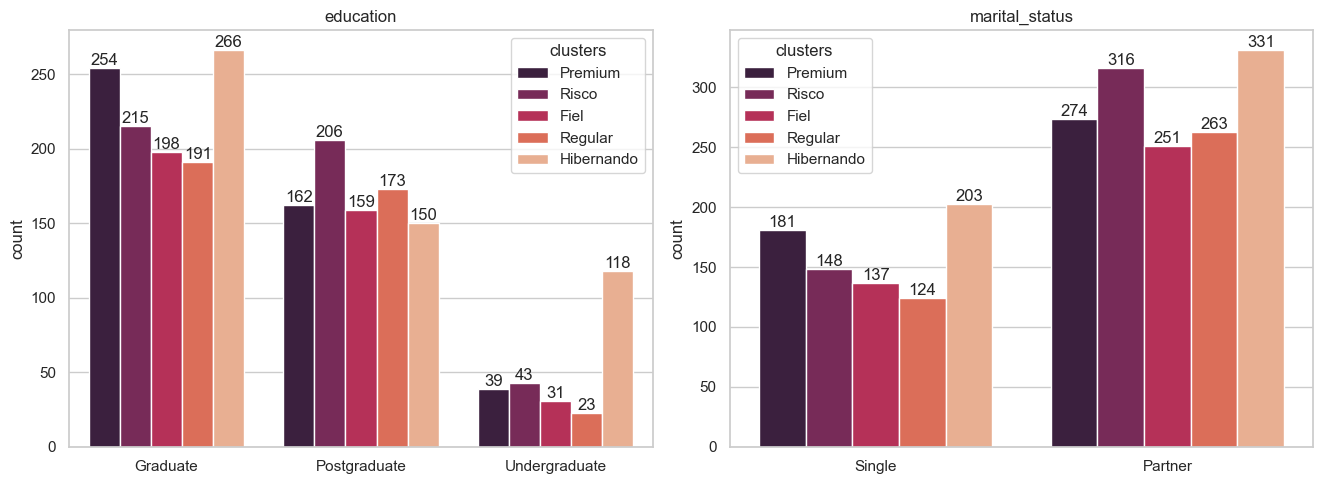

In [22]:
sns_plots(data=customer_clusters, features=categorical_features, plot_type='count', hue='clusters', palette='rocket')

- A maior parte dos clientes que fazem graduação pertencem ao cluster 0 (Hibernando), em média eles são o grupo mais jovem no nosso data
- Entre os Pós Graduados o cluster 4 (Risco) representam a maior parte.
- Em Não Graduados o cluster 0 (Hibernando) representa a maior parte
- Em marital_status cluster 0 (Hibernando) representa o maior numero de solteiros e parceiros


# Programa de Fidelidade


Nessa etapa iremos selecionar os clientes mais valiosos para o programa de fidelidade, Para aumentar a receita após a implementação do programa de fidelidade, estratégias como oferecer descontos, produtos exclusivos e campanhas de marketing direcionadas podem ser empregadas.

Irei examinar os clusters para comparar qual possui a maior contribuição na receita , taxa de frequência e quanto cada grupo representa do total dos nosso dados.

In [23]:
def round_frequency(series):
    return round(series.mean(), 2)

# Agrupar os dados por cluster e calcular as métricas
cluster_summary = customer_clusters.groupby('clusters').agg(
    avg_frequency=('frequency', round_frequency),  # Frequência média
)

# Calcular o total de revenue de todos os clientes
total_revenue = customer_clusters['monetary'].sum()
cluster_summary['percentage_of_revenue'] = (customer_clusters.groupby('clusters')['monetary'].sum() / total_revenue) * 100

# Calcular a porcentagem de clientes por cluster
total_customers = len(customer_clusters)  # Total de clientes
cluster_counts = customer_clusters['clusters'].value_counts()  # Contagem de clientes por cluster
cluster_summary['percentage_of_customers'] = (cluster_counts / total_customers) * 100

# Calcular a razão de frequência de cada cluster em relação à média global
mean_frequency_all = customer_clusters['frequency'].mean()  # Média de frequência de todos os clientes
cluster_summary['frequency_ratio'] = cluster_summary['avg_frequency'] / mean_frequency_all

# Arredondando as colunas de porcentagem e a razão de frequência para 2 casas decimais
cluster_summary['percentage_of_revenue'] = cluster_summary['percentage_of_revenue'].round(2)
cluster_summary['percentage_of_customers'] = customer_clusters.groupby('clusters').size() / len(customer_clusters) * 100
cluster_summary['percentage_of_customers'] = cluster_summary['percentage_of_customers'].round(2)
cluster_summary['frequency_ratio'] = cluster_summary['frequency_ratio'].round(2)

# Remover a coluna avg_frequency, pois você não deseja exibi-la
cluster_summary.drop(columns=['avg_frequency'], inplace=True)

cluster_summary = cluster_summary.sort_values(by=['percentage_of_revenue'], ascending=False)

# Exibindo o DataFrame final
cluster_summary




percentage_of_revenue  percentage_of_customers  frequency_ratio
clusters                                                                   
Premium                     49.15                    20.42             1.37
Fiel                        29.95                    17.41             1.55
Regular                     14.08                    17.37             1.24
Risco                        3.63                    20.83             0.57
Hibernando                   3.19                    23.97             0.48



Nosso **Programa de Fidelidade** foi desenvolvido para incentivar o aumento de gastos dos clientes em diferentes segmentos, considerando o perfil de cada grupo (cluster). A estratégia é direcionada para três categorias de clientes com grande potencial de engajamento e retorno financeiro: **Premium**, **Fiel** e **Regular**.

## Estratégia do Programa

### **Premium (20% de aumento esperado):**
Os clientes Premium são altamente engajados e possuem um histórico consistente de compras. Nosso programa oferece:
- Descontos antecipados;
- Acesso a eventos especiais;
- Ofertas personalizadas.

O objetivo é aumentar ainda mais os gastos neste segmento.

---

### **Fiel (15% de aumento esperado):**
Esses clientes já apresentam um relacionamento sólido com a empresa. As ações incluem:
- Recompensas baseadas na fidelidade, como pontos bônus;
- Benefícios de longo prazo;
- Programas de recomendação para amigos.

O objetivo é fortalecer o vínculo e aumentar a recorrência de compras.

---

### **Regular (10% de aumento esperado):**
Clientes regulares possuem um potencial de crescimento moderado. Para incentivá-los:
- Promoções em produtos populares;
- Incentivos para compras recorrentes;
- Programas de adesão.

O objetivo é aumentar sua frequência de compra e o valor médio das transações.

---

## Cálculo do Impacto Financeiro

### 1. Ajuste nos Valores de Gasto (`monetary`)
Para medir o impacto do programa, aplicamos aumentos nos valores gastos pelos clientes com base no cluster ao qual pertencem:
- **Premium**: Gastos aumentam em 20% (multiplicados por 1.2).
- **Fiel**: Gastos aumentam em 15% (multiplicados por 1.15).
- **Regular**: Gastos aumentam em 10% (multiplicados por 1.10).

Clientes de outros clusters, como **Risco** e **Hibernando**, não recebem ajustes, pois o programa não é voltado para esses segmentos no momento.

---

### 2. Comparação Antes e Depois
Comparamos o total de receita antes e depois da implementação do programa. Este cálculo mostra a diferença gerada pelo aumento nos gastos esperados nos clusters-alvo. Por exemplo:
- **Receita Antes do Programa**: `$500,000`
- **Receita Após o Programa**: `$575,000`
  - **Aumento Absoluto**: `$75,000`
  - **Aumento Percentual**: `15%`

---

### 3. Cenários de Impacto
Este modelo permite projetar diferentes cenários financeiros, como:
- O impacto de um percentual maior de clientes migrar para os clusters Premium ou Fiel.
- Estratégias específicas para aumentar o engajamento dos clusters menos engajados.

---

## Benefícios do Programa

- **Aumento de Receita**: Clientes nos clusters Premium, Fiel e Regular gastarão mais devido às vantagens oferecidas.
- **Fidelização**: Ao estreitar o relacionamento com os clientes, aumentamos a probabilidade de retenção e reduzimos o churn.
- **Segmentação Efetiva**: Concentramos esforços e recursos nos grupos com maior retorno esperado, otimizando o impacto financeiro.

---

Este programa não apenas fortalece a relação com os clientes, mas também oferece uma ferramenta estratégica para impulsionar a receita de maneira sustentável, com base em análises detalhadas do comportamento do cons
ntável, com base em análises detalhadas do comportamento do consumidor.
e em análises detalhadas do comportamento do consumidor.


In [24]:
total_revenue_before = customer_clusters['monetary'].sum()


# Ajuste as frações para cada cluster com base na estratégia
random_samples_indexes = customer_clusters.loc[customer_clusters['clusters'] == 'Regular'].sample(frac=0.3).index
customer_clusters.loc[random_samples_indexes, 'clusters'] = 'Premium'

random_samples_indexes = customer_clusters.loc[customer_clusters['clusters'] == 'Risco'].sample(frac=0.1).index
customer_clusters.loc[random_samples_indexes, 'clusters'] = 'Fiel'

random_samples_indexes = customer_clusters.loc[customer_clusters['clusters'] == 'Hibernando'].sample(frac=0.05).index
customer_clusters.loc[random_samples_indexes, 'clusters'] = 'Regular'



# Mapeamento dos clusters para os respectivos aumentos
increase_mapping = {
    'Premium': 1.2,
    'Fiel': 1.15,
    'Regular': 1.10
}

customer_clusters['monetary'] = customer_clusters['monetary'] * customer_clusters['clusters'].map(increase_mapping).fillna(1)


# Receita total após o programa de fidelidade
total_revenue_after = customer_clusters['monetary'].sum()

# Cálculo do impacto
revenue_increase_absolute = total_revenue_after - total_revenue_before
revenue_increase_percentage = (revenue_increase_absolute / total_revenue_before) * 100


print(f'Receita total antes do programa: ${round(total_revenue_before, 2):,.2f}')
print(f'Receita total após programa: ${round(total_revenue_after, 2):,.2f}')
print(f'Aumento de Receita: {revenue_increase_percentage:.2f}%')
print(f'Aumento de Receita em Termo Absoluto: ${round(revenue_increase_absolute, 2):,.2f}')


Receita total antes do programa: $1,348,072.00
Receita total após programa: $1,566,852.70
Aumento de Receita: 16.23%
Aumento de Receita em Termo Absoluto: $218,780.70
